In [1]:
import json

import IPython
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.io.wavfile
import scipy.signal

In [2]:
print('IPython.__version__ = %s' % IPython.__version__)
print('numpy.__version__ = %s' % np.__version__)
print('matplotlib.__version__ = %s' % matplotlib.__version__)
print('scipy.__version__ = %s' % scipy.__version__)

IPython.__version__ = 7.9.0
numpy.__version__ = 1.18.3
matplotlib.__version__ = 3.0.3
scipy.__version__ = 1.4.1


In [3]:
!ls ../audios

0WtRNGubWGA.wav  Dkk9gvTmCXY.wav  JGhoLcsr8GA.wav  wr2sVPTacTE.wav
1EadhOBcfI0.wav  DyDfgMOUjCI.wav  oygrmJFKYZY.wav  YVkUvmDQ3HY.wav
5ePLlJmZ_bk.wav  II2EO3Nw4m0.wav  QK8mJJJvaes.wav
8UVNT4wvIGY.wav  jGflUbPQfW8.wav  TjUXr560Gu0.wav


In [4]:
kelly_wife_or_dog = 'wr2sVPTacTE'
dhoom_taana = 'TjUXr560Gu0'
video_name = kelly_wife_or_dog
# video_name = dhoom_taana
rate, data = scipy.io.wavfile.read('../audios/%s.wav' % video_name)
print('data.shape = %s' % str(data.shape))
print('data.dtype = %s' % data.dtype)

data.shape = (4165415, 2)
data.dtype = int16


In [5]:
length = data.shape[0] / rate
print('number of channels = %d' % data.shape[1])
print('length = %f seconds' % length)

if data.shape[1] > 1:
    print('selecting channel 0')
    data = data[:, 0]
    
limit = 60
if length > limit:
    print('shortening to %d seconds' % limit)
    data = data[:limit * rate].copy()
    length = float(limit)
    
print('final shape = %s' % str(data.shape))

number of channels = 2
length = 86.779479 seconds
selecting channel 0
shortening to 60 seconds
final shape = (2880000,)


In [6]:
# I decided to use `stft` instead of `spectrogram` because it seemed simpler to understand it's
# "window" and "overlap" arguments.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html vs
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html . 
# The `spectrogram` documentation has a nice overview, but does a poor job at explaining
# windows with respect to the `window` argument. I tried also looking at
# https://homes.cs.washington.edu/~thickstn/spectrograms.html but ultimately settled on
# `stft`. Note that the result of `stft` is in the complex domain, so we have to use the
# magnitude to get a real value.
window_size = int(rate) // 100
freqs, times, spectro = scipy.signal.stft(
    data,
    rate,
    window='hann', # default, as specified by the documentation (listed above)
    nperseg=window_size,
    noverlap=window_size // 2
)
# Note that my interpretation of spectro is more like spectro.T. In that, each row in
# spectro.T represents the frequency strengths at a particular time. Specifically,
# spectro.T[0] represents the first 10 ms of `data`
print('data.shape = %s' % str(data.shape))
print('spectro.shape = %s' % str(spectro.shape))
print('(spectro.shape[0] - 1) * (spectro.shape[1] - 1) = %d' % ((spectro.shape[0] - 1) * (spectro.shape[1] - 1)))
print('spectro.dtype = %s' % spectro.dtype)

data.shape = (2880000,)
spectro.shape = (241, 12001)
(spectro.shape[0] - 1) * (spectro.shape[1] - 1) = 2880000
spectro.dtype = complex64


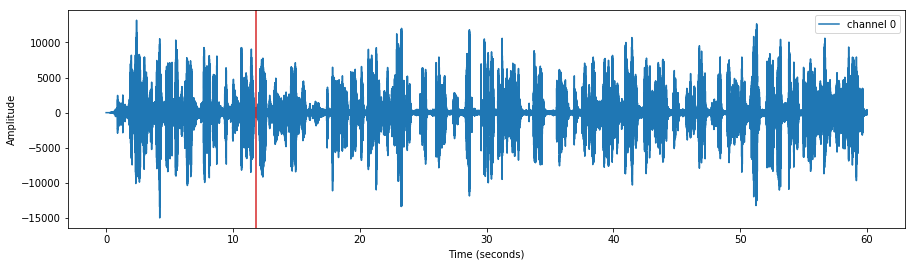

In [7]:
time_range = np.linspace(0, length, data.shape[0])
plt.plot(time_range, data, label='channel 0')

# Some interesting markers
if video_name == dhoom_taana:
    # The start of the chorus
    plt.axvline(x=34, color='#d62728')
    # The start of the solo singer, "Kaise, ..."
    plt.axvline(x=43, color='#d62728')
elif video_name == kelly_wife_or_dog:
    # The long, slow "Sooooo, Kelly..."
    plt.axvline(x=11.8, color='#d62728')

plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.gcf().set_size_inches([15, 4]) # default is 6 x 4
plt.show()

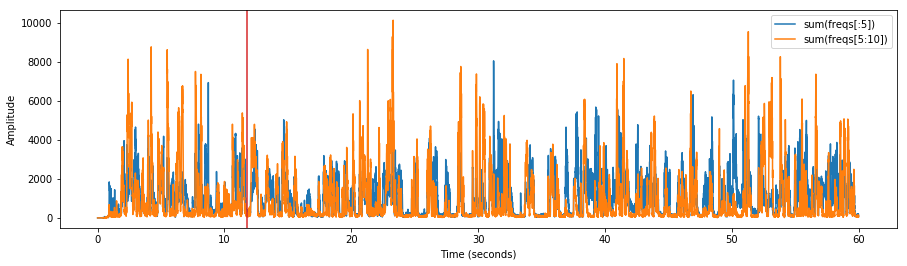

In [8]:
time_range = np.linspace(0, limit, spectro.shape[1])
signal1 = np.abs(spectro).T[:, :5].sum(axis=1)
signal2 = np.abs(spectro).T[:, 5:10].sum(axis=1)
plt.plot(time_range, signal1, label='sum(freqs[:5])')
plt.plot(time_range, signal2, label='sum(freqs[5:10])')

# Some interesting markers
if video_name == dhoom_taana:
    # The start of the chorus
    plt.axvline(x=34, color='#d62728')
    # The start of the solo singer, "Kaise, ..."
    plt.axvline(x=43, color='#d62728')
elif video_name == kelly_wife_or_dog:
    # The long, slow "Sooooo, Kelly..."
    plt.axvline(x=11.8, color='#d62728')

plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.gcf().set_size_inches([15, 4]) # default is 6 x 4
plt.show()

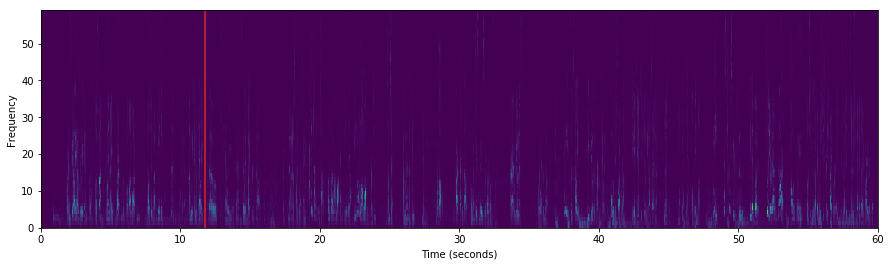

In [9]:
# I'm using `np.arange(freqs.shape[0])` instead of `freqs` directly
# because that's just how I think about frequencies...
plt.pcolormesh(times, np.arange(freqs.shape[0])[:60], np.abs(spectro)[:60, :])

# Some interesting markers
if video_name == dhoom_taana:
    # The start of the chorus
    plt.axvline(x=34, color='#d62728')
    # The start of the solo singer, "Kaise, ..."
    plt.axvline(x=43, color='#d62728')
elif video_name == kelly_wife_or_dog:
    # The long, slow "Sooooo, Kelly..."
    plt.axvline(x=11.8, color='#d62728')
    
plt.ylabel('Frequency')
plt.xlabel('Time (seconds)')
plt.gcf().set_size_inches([15, 4]) # default is 6 x 4
plt.show()

In [10]:
# Pass in the transpose of `data` (`data.T`) because IPython expects
# a different shape than what scipy returns.
# https://stackoverflow.com/questions/57137050/i-am-facing-problems-displaying-audio-file-using-python
IPython.display.Audio(data=data.T, rate=rate)

In [11]:
# Starts at about ~34 seconds
dhoom_taana_lyrics = """
Dhoom Taana Ta Dum Ta Na Na Na
Dhoom Taana Ta Dum Ta Na Na Na
Dhoom Taana Dhir Na Dhir Na...

Kaise, Naino Se Nain Milao Sajna
Kaise, Mein Aise Na Ghabrao Sajna
Kaise, Aaye Na Aise Mohe Laaj Sajna
Choona Na Dehko Mohe Aaj Sajna
"""
# Ends half way through "mohe" (doesn't get to finish "aaj sajna").
# Per line, there are 8, 8, and 6 sounds and then 6, 6, 7, and finally
# 3.5 words that are uttered in the first 60 seconds of the song.

kelly_wife_or_dog_utterances = []
with open('../outputs/%s.json' % kelly_wife_or_dog, 'rb') as f:
    raw_output = json.loads(f.read().decode('utf-8'))
    
result_items = raw_output['results']['items']
for item in result_items:
    if 'start_time' not in item:
        continue
    start_time = float(item['start_time'])
    if start_time > limit:
        continue
    end_time = float(item['end_time'])
    kelly_wife_or_dog_utterances.append({
        'start': start_time,
        'end': end_time,
        'duration': end_time - start_time,
        'content': item['alternatives'][0]['content'],
    })
    print(kelly_wife_or_dog_utterances[-1])
    
print('num utterances = %d' % len(kelly_wife_or_dog_utterances))

{'duration': 0.5699999999999998, 'end': 2.57, 'start': 2.0, 'content': 'Skelley'}
{'duration': 0.13000000000000034, 'end': 2.7, 'start': 2.57, 'content': 'How'}
{'duration': 0.10999999999999988, 'end': 2.81, 'start': 2.7, 'content': 'was'}
{'duration': 0.10999999999999988, 'end': 2.92, 'start': 2.81, 'content': 'your'}
{'duration': 0.5300000000000002, 'end': 3.45, 'start': 2.92, 'content': 'weekend'}
{'duration': 0.54, 'end': 4.45, 'start': 3.91, 'content': 'Fun'}
{'duration': 0.2400000000000002, 'end': 4.88, 'start': 4.64, 'content': 'coming'}
{'duration': 0.1200000000000001, 'end': 5.0, 'start': 4.88, 'content': 'and'}
{'duration': 0.1200000000000001, 'end': 5.12, 'start': 5.0, 'content': 'I'}
{'duration': 0.20999999999999996, 'end': 5.33, 'start': 5.12, 'content': 'hit'}
{'duration': 0.45999999999999996, 'end': 5.8, 'start': 5.34, 'content': 'Park'}
{'duration': 0.2400000000000002, 'end': 6.05, 'start': 5.81, 'content': 'would'}
{'duration': 0.14000000000000057, 'end': 6.2, 'start':